# **ANÁLISE DE IMAGENS DE RAIOS X COM REDES NEURAIS CONVOLUCIONAIS PARA DETECÇÃO DE COVID-19**

## **OBJETIVO**

 O objetivo desse notebook é tanto introduzir  Redes Neurais Convolucionais **(CNN)**, como verificar sua eficiência em classificação binária de imagens. Para tal, escolhi um conjunto de dados disponível em: [text](https://github.com/AlaaSulaiman/COVID19-vs-Normal-dataset/blob/master/COVID19-vs-Normal%20dataset.rar).

 Vejamos uma pequena amostra desses dados abaixo:

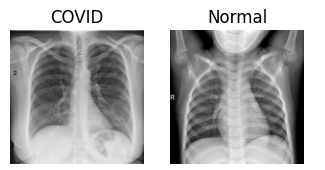

Nota-se a olho nu a diferença entre um indivíduo saudável e um indivíduo com Covid-19: verifique as manchas brancas no pulmão do indivíduo a esquerda e compare com o pulmão de alguém saudável(direita)


Pergunta: É possível atingir o mesmo resultado usando visão computacional e redes neurais convolucionais? 

## **CARREGAMENTO E CONVERSÃO DOS DADOS**

Nesta etapa, é realizado o carregamento das imagens de raio-x de pacientes, tanto com **COVID-19** quanto sem, e as transformamos em matrizes **NUMPY**. Esse processo é essencial para preparar os dados no formato adequado para o treinamento do modelo de rede neural convolucional **(CNN)**. As imagens são convertidas para arrays **NUMPY**, que permitem a manipulação eficiente dos dados, facilitando o processamento, normalização e aplicação das técnicas de **ML**.

In [1]:

import os
import numpy as np
from PIL import Image


def load_images_from_folder(folder, label, target_size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('RGB') # Garantindo que a imagem está no modo RGB
            img = img.resize(target_size) 
            img_array = np.array(img)
            images.append(img_array)
            labels.append(label)
    return images, labels

#  caminhosnormal_folder = r'C:\Users\joaol\Downloads\covid_19\400 Normal images'
covid_folder = r'C:\Users\joaol\Downloads\covid_19\400 Covid images'

# imagens e seus respectivos rótulos
normal_images, normal_labels = load_images_from_folder(normal_folder, label=False)
covid_images, covid_labels = load_images_from_folder(covid_folder, label=True)

images = np.array(normal_images + covid_images)
labels = np.array(normal_labels + covid_labels)


indices = np.arange(len(images))
np.random.shuffle(indices)
images = images[indices]
labels = labels[indices]

# Salvando tudo em arquivo .npy
np.save('images.npy', images)
np.save('labels.npy', labels)
print("Dataset saved successfully!")

Dataset saved successfully!


## **VERIFICAÇÃO DE INTEGRIDADE DO DATASET**

Nesta etapa, realiza-se uma verificação da integridade das imagens salvas e visualiza-se algumas delas para garantir que o processo de carregamento e armazenamento foi realizado corretamente. Utiliza-se o **NUMPY** para carregar os arrays de imagens e rótulos armazenados no arquivo .npy. A função **DISPLAY_IMAGES** foi implementada para exibir uma seleção aleatória de imagens junto com seus respectivos rótulos, indicando se a imagem corresponde a um caso de **COVID-19** ou a um paciente normal. Ao renderizar  dez imagens, conseguimos observar a variedade e a qualidade das imagens do nosso conjunto de dados, assegurando que estão prontas para as próximas etapas de processamento e análise.

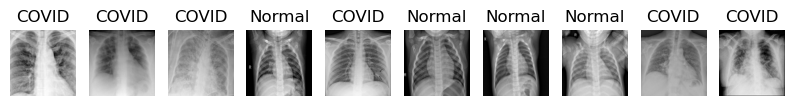

In [2]:

import matplotlib.pyplot as plt
import numpy as np


images = np.load('images.npy')
labels = np.load('labels.npy')

#   imagens e seus rótulos
def display_images(images, labels, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        j = np.random.randint(0, images.shape[0])
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[j])
        label = 'COVID' if labels[j] else 'Normal'
        plt.title(label)
        plt.axis('off')  

    plt.show()

# Renderizando algumas imagens
display_images(images, labels, num_images=10)

# Processo de Desenvolvimento do Modelo CNN para Detecção de COVID-19

Nesta etapa realizo o pré-processamento dos dados e configuro o modelo CNN para detecção de COVID-19 em radiografias. Primeiro carrego as imagens e rótulos, normalizando os valores dos pixels para o intervalo [0,1] para melhorar a eficiência do treinamento.

## Construção do Modelo
- Crio uma CNN com 3 camadas convolucionais + max pooling
- Adiciono camada densa com dropout para regularização
- Saída com ativação sigmoid (classificação binária)
- Escolha entre focal loss (dados desbalanceados) ou binary crossentropy
- Modelo compilado com Adam e learning rate configurável

## Hiperparâmetros
Divido em dois grupos:
1. `model_hyperparams`: controlam arquitetura (filtros, dropout, learning rate)
2. `training_hyperparams`: controlam treino (batch size, epochs)

## Busca Aleatória (20 combinações)
Para cada iteração:
1. Seleciono valores aleatórios para cada hiperparâmetro
2. Construo o modelo com `build_model()`
3. Treino com EarlyStopping (patience=3)
4. Avalio acurácia na validação
5. Mantenho registro da melhor combinação

## Resultados


**Observações:**
- Dados divididos em 70% treino, 20% validação, 10% teste
- Como as imagens têm ângulo e dimensões consistentes, não preciso fazer data augmentation


In [3]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_curve, roc_auc_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import tensorflow as tf
import seaborn as sns

images = np.load('images.npy')
labels = np.load('labels.npy')
images = images.astype('float32') / 255.0

# Divisão 70% treino, 20% validação, 10% teste (estratificada)
X_temp, X_test, y_temp, y_test = train_test_split(
    images, labels, 
    test_size=0.1, 
    random_state=666,
    stratify=labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.2222,  # 0.2222 * 0.9 = 0.2 (20% do total)
    random_state=666,
    stratify=y_temp
)

print(f"Treino: {X_train.shape[0]} amostras (70%)")
print(f"Validação: {X_val.shape[0]} amostras (20%)")
print(f"Teste: {X_test.shape[0]} amostras (10%)")

# Verificar balanceamento
print("\nBalanceamento:")
for name, y in zip(['Treino', 'Validação', 'Teste'], [y_train, y_val, y_test]):
    print(f"{name}: Classe 0 = {np.sum(y == 0)}, Classe 1 = {np.sum(y == 1)}")

Treino: 560 amostras (70%)
Validação: 160 amostras (20%)
Teste: 80 amostras (10%)

Balanceamento:
Treino: Classe 0 = 280, Classe 1 = 280
Validação: Classe 0 = 80, Classe 1 = 80
Teste: Classe 0 = 40, Classe 1 = 40


## **BUSCA POR HIPERPARAMETROS E FORMULAÇÃO DO MODELO**

In [4]:
# modelo 
def build_model(filters=32, dropout_rate=0.3, learning_rate=0.001, use_focal_loss=False):
    model = Sequential([
        Conv2D(filters, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    loss_fn =  'binary_crossentropy'
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=loss_fn,
        metrics=['accuracy']
    )
    return model

# Hiperparâmetros 
model_hyperparams = {
    'filters': [32, 64],
    'dropout_rate': [0.3, 0.5],
    'learning_rate': [0.001, 0.0001],
    'use_focal_loss': [True, False]
}

training_hyperparams = {
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

# Busca randomica(20 comb.)
best_val_acc = 0
best_model_params = None
best_training_params = None
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

for i in range(20):
    #
    current_model_params = {k: np.random.choice(v) for k, v in model_hyperparams.items()}
    current_training_params = {k: np.random.choice(v) for k, v in training_hyperparams.items()}
    
    print(f"\nCombinação {i+1}:")
    print(f"Modelo: {current_model_params}")
    print(f"Treino: {current_training_params}")
    
    # Constrói e treina o modelo
    model = build_model(**current_model_params)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=current_training_params['epochs'],
        batch_size=current_training_params['batch_size'],
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Avalia no conjunto de validação
    val_acc = history.history['val_accuracy'][-1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_params = current_model_params
        best_training_params = current_training_params
        print(f"Novo melhor: val_acc = {val_acc:.4f}")

print("\nMelhores parâmetros encontrados:")
print("Parâmetros do Modelo:", best_model_params)
print("Parâmetros de Treino:", best_training_params)
print(f"Melhor Acurácia de Validação: {best_val_acc:.4f}")


Combinação 1:
Modelo: {'filters': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'use_focal_loss': False}
Treino: {'batch_size': 64, 'epochs': 10}


c:\Users\joaol\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Novo melhor: val_acc = 0.9937

Combinação 2:
Modelo: {'filters': 64, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'use_focal_loss': False}
Treino: {'batch_size': 64, 'epochs': 20}

Combinação 3:
Modelo: {'filters': 64, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'use_focal_loss': False}
Treino: {'batch_size': 64, 'epochs': 20}

Combinação 4:
Modelo: {'filters': 32, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'use_focal_loss': False}
Treino: {'batch_size': 64, 'epochs': 10}

Combinação 5:
Modelo: {'filters': 64, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'use_focal_loss': True}
Treino: {'batch_size': 32, 'epochs': 10}

Combinação 6:
Modelo: {'filters': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'use_focal_loss': False}
Treino: {'batch_size': 64, 'epochs': 10}
Novo melhor: val_acc = 1.0000

Combinação 7:
Modelo: {'filters': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'use_focal_loss': True}
Treino: {'batch_size': 64, 'epochs': 20}

Combinação 8:
Modelo: {'filters': 64, 

In [5]:

X_train_final = np.concatenate([X_train, X_val])
y_train_final = np.concatenate([y_train, y_val])

final_model = build_model(**best_model_params)

history = final_model.fit(
    X_train_final,
    y_train_final,
    epochs=best_training_params['epochs'],
    batch_size=best_training_params['batch_size'],
    verbose=1
)


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 370ms/step - accuracy: 0.6100 - loss: 0.7242
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 347ms/step - accuracy: 0.9614 - loss: 0.1700
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 355ms/step - accuracy: 0.9747 - loss: 0.1029
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 380ms/step - accuracy: 0.9823 - loss: 0.0679
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 370ms/step - accuracy: 0.9849 - loss: 0.0562
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 365ms/step - accuracy: 0.9924 - loss: 0.0245
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 350ms/step - accuracy: 0.9897 - loss: 0.0352
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 345ms/step - accuracy: 0.9964 - loss: 0.0312
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 357ms/step - accuracy: 0.9894 - loss: 0.0251
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 360ms/step - accuracy: 0.9957 - loss: 0.0140


**Observação rápida:** Depois de usar o conjunto de *validação* para escolher os melhores hiperparâmetros, eu colo esses exemplos de volta no treino. Assim o modelo final aprende com **90 %** dos dados (treino + validação) e o conjunto de **teste** fica guardado, intocável, só pra avaliação final.

## **MÉTRICAS DE CLASSIFICAÇÃO E MATRIZ DE CONFUSÃO**

In [7]:
from sklearn.metrics import classification_report, confusion_matrix

print("\nAvaliando o desempenho no conjunto de teste...")
y_test_pred_prob = final_model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).flatten()


if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)
else:
    y_test = y_test.flatten().astype(int)

test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=0)

print("\nDesempenho no Conjunto de Teste:")
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

print("\nDistribuição das classes no conjunto de teste:")
print(f"Classes verdadeiras (y_test): {np.bincount(y_test)}")
print(f"Classes preditas (y_test_pred): {np.bincount(y_test_pred)}")

print("\nGerando matriz de confusão para o conjunto de teste...")
cm = confusion_matrix(y_test, y_test_pred)
print("Matriz de Confusão (Teste):")
print(cm)

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_test_pred, digits=4))



Avaliando o desempenho no conjunto de teste...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

Desempenho no Conjunto de Teste:
Test Accuracy: 1.0000, Test Loss: 0.0015

Distribuição das classes no conjunto de teste:
Classes verdadeiras (y_test): [40 40]
Classes preditas (y_test_pred): [40 40]

Gerando matriz de confusão para o conjunto de teste...
Matriz de Confusão (Teste):
[[40  0]
 [ 0 40]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        40
           1     1.0000    1.0000    1.0000        40

    accuracy                         1.0000        80
   macro avg     1.0000    1.0000    1.0000        80
weighted avg     1.0000    1.0000    1.0000        80



## **VISUALIZAÇÃO DA CURVA AUC-ROC**


Gerando curva ROC-AUC para o conjunto de teste...


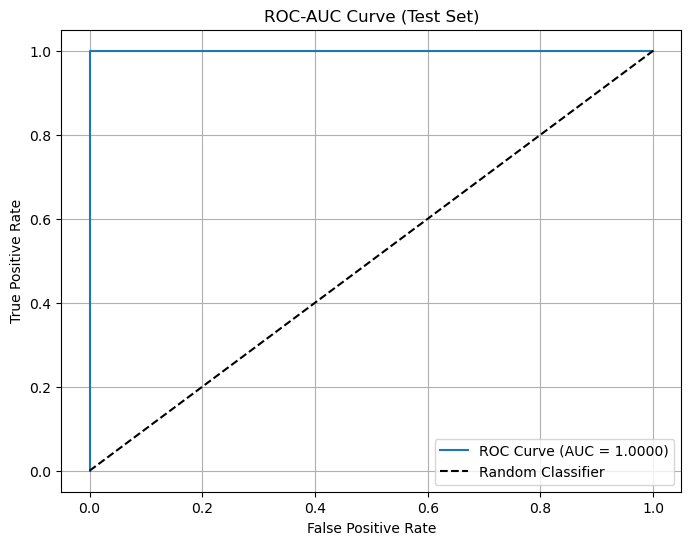

In [8]:

print("\nGerando curva ROC-AUC para o conjunto de teste...")
fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
auc = roc_auc_score(y_test, y_test_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve (Test Set)')
plt.legend()
plt.grid(True)
plt.savefig('roc_curve.png')
plt.show()

## **CONCLUSÃO**


O modelo é muito bom para classificar entre  casos de Covid-19 e casos normais, observe que as métricas em geral obtiveram resultados acima de 99%. Contudo, não é possível generalizar essa arquitetura nem hiperparâmetros para um pool maior de dados pois esse conjunto é muito específico e isso pode gerar viés -- precisamos testar em conjuntos com imagens de menor resolução e em diferentes fases do avanço da doença. 